In [1]:
import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from collections import Counter

In [2]:
class Args():
    
    model_type='bert'
    run_id=1
    file_train='gender_data_for_inlp_train'
    file_dev='gender_data_for_inlp_dev'
    file_test='gender_data_for_inlp_dev'
    
args=Args()

In [6]:
def load_data(args, file):
    
    with open(file, "rb") as f:
        data=pickle.load(f)
        z=np.array([1 if d["g"]=="f" else 0 for d in data])
        stereotypes=np.array([d["s"] for d in data])
        txts=[d["text"] for d in data]
    
    return z, txts, stereotypes, data

def load_data_representations(args, file, seed=0):
    
    X=np.load("encodings/{}/{}.npy".format(args.model_type, file))
    
    with open("pca/pca_{}_{}.pickle".format(args.model_type, args.run_id), "rb") as f:
        pca=pickle.load(f)
    X=pca.transform(X)
    
    return X

def load_projections(proj_type, seed=0):
    
    with open("interim/{}/{}/Ps_{}.pickle".format(args.model_type, proj_type, proj_type), "rb") as f:
        rank2P=pickle.load(f)
        
        return rank2P             

In [7]:
pickle_file_train="./data_for_inlp/{}.pickle".format(args.file_train)
pickle_file_dev="./data_for_inlp/{}.pickle".format(args.file_dev)
pickle_file_test="./data_for_inlp/{}.pickle".format(args.file_test)

z_train,txts_train,stereotypes_train,train = load_data(args, pickle_file_train)
z_test,txts_test,stereotypes_test,test = load_data(args, pickle_file_test)
z_dev,txts_dev,stereotypes_dev,dev = load_data(args, pickle_file_dev)

if False and os.path.exists("analysis/") and os.path.exists("analysis/mode2x.pickle") and os.path.exists("analysis/mode2p.pickle"):
    with open("analysis/mode2p.pickle", "rb") as f:
        mode2p = pickle.load(f)
    with open("analysis/mode2x.pickle", "rb") as f:
        mode2x = pickle.load(f)
        
else:
    if not os.path.exists("analysis"): os.mkdir("analysis")
    mode2x = defaultdict(dict)
    mode2p = defaultdict(dict)
    
    mode2x["train"]=load_data_representations(args, args.file_train)
    mode2x["dev"]=load_data_representations(args, args.file_dev)
    mode2x["test"]=load_data_representations(args, args.file_test)
    
    for projtype in ["rlace", "inlp"]:
        rank2P=load_projections(projtype)
        mode2p[projtype]=rank2P
        
    with open("analysis/mode2x.pickle", "wb") as f:
        pickle.dump(mode2x, f)
    with open("analysis/mode2p.pickle", "wb") as f:
        pickle.dump(mode2p, f)

In [9]:
with open("analysis/mode2x.pickle", "rb") as f:
        mode2x = pickle.load(f)
with open("analysis/mode2p.pickle", "rb") as f:
        mode2p = pickle.load(f)

## classifiers

In [23]:
def train_classifier(X, y, X_dev, y_dev, X_test, y_test):
    random.seed(0)
    np.random.seed(0)

    #clf=SGDClassifier(loss="log", fit_intercept=True, max_iter=3, tol=0.1*1e-3, n_iter_no_change=1)
    clf=LogisticRegression(warm_start=True, penalty='l2', solver="saga", multi_class='multinomial', fit_intercept=True, verbose=5, n_jobs=64, random_state=1, max_iter=10)

    clf.fit(X,y)
    score_dev=clf.score(X_dev, y_dev)
    score_test=clf.score(X_test, y_test)

    return clf, score_dev, score_test

random.seed(0)
np.random.seed(0)

stereotype_clfs=defaultdict(dict)
attr_clfs=defaultdict(dict)

for do_projection in [False, True]:
    X_train=mode2x['train']
    X_dev=mode2x['dev']
    X_test=mode2x['test']

    if not do_projection:
        stereo_clf, stereo_score_dev, stereo_score_test=train_classifier(X_train, stereotypes_train, X_dev, stereotypes_dev, X_test, stereotypes_test)
        stereotype_clfs[do_projection]={"clf": stereo_clf, "dev_score": stereo_score_dev, "test_score": stereo_score_test}

        attr_clf, attr_score_dev, attr_score_test=train_classifier(X_train, z_train, X_dev, z_dev, X_test, z_test)
        attr_clfs[do_projection]={"clf": attr_clf, "dev_score": attr_score_dev, "test_score": attr_score_test}

        print("here", attr_score_dev, stereo_score_dev)
    else:

        stereotype_clfs[do_projection]=defaultdict(dict)
        attr_clfs[do_projection]=defaultdict(dict)

        for projtype in ["rlace", "inlp"]:
            for rank in [1, 4, 8, 16, 32, 50, 64, 100]:
                print(projtype, rank)
                P=mode2p[projtype][0][rank if projtype=="rlace" else rank-1]
                stereo_clf, stereo_score_dev, stereo_score_test=train_classifier(X_train@P, stereotypes_train, X_dev@P, stereotypes_dev, X_test@P, stereotypes_test)
                stereotype_clfs[do_projection][projtype][rank]={"clf": stereo_clf, "dev_score": stereo_score_dev, "test_score": stereo_score_test}

                attr_clf, attr_score_dev, attr_score_test=train_classifier(X_train@P, z_train, X_dev@P, z_dev, X_test@P, z_test)
                attr_clfs[do_projection][projtype][rank]={"clf": attr_clf, "dev_score": attr_score_dev, "test_score": attr_score_test}

                print("here", stereo_score_dev, attr_score_dev)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 17 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   16.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.925777331995988 0.4704112337011033
rlace 1


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds
here 0.46439317953861586 0.8194583751253761
rlace 4


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4653961885656971 0.8194583751253761
rlace 8


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4653961885656971 0.8194583751253761
rlace 16


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4653961885656971 0.8194583751253761
rlace 32


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.46138415245737213 0.8194583751253761
rlace 50


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4663991975927783 0.8194583751253761
rlace 64


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.46439317953861586 0.8194583751253761
rlace 100


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 15 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4724172517552658 0.8194583751253761
inlp 1


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 15 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.4s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4724172517552658 0.9137412236710131
inlp 4


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 15 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.5s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4653961885656971 0.8625877632898696
inlp 8


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 15 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4663991975927783 0.8164493480441324
inlp 16


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds
here 0.46238716148445336 0.8194583751253761
inlp 32


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.46238716148445336 0.8194583751253761
inlp 50


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.4724172517552658 0.8194583751253761
inlp 64


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.477432296890672 0.8194583751253761
inlp 100


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 14 seconds


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:   14.3s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
here 0.49949849548645936 0.8194583751253761


c:\users\31631\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished


In [25]:
with open("analysis/attr_gender_clfs.pickle", "wb") as f:
    pickle.dump(attr_clfs, f)

with open("analysis/stereotypes_gender_clfs.pickle", "wb") as f:
    pickle.dump(stereotype_clfs, f)

In [26]:
with open("analysis/attr_gender_clfs.pickle", "rb") as f:
    attr_clfs=pickle.load(f)

with open("analysis/stereotypes_gender_clfs.pickle", "rb") as f:
    stereotype_clfs=pickle.load(f)

## accuracy vs rank

In [47]:
def create_df(clf_dict, projtype, do_projection):
    d=defaultdict(dict) if do_projection else dict()
    ranks=[1, 4, 8, 16, 32, 50, 64, 100]

    if not do_projection:
        d=clf_dict[do_projection]["test_score"]
    else:
        for rank in ranks:
            d[rank]=clf_dict[do_projection][projtype][rank]["test_score"]

    try:
        df=pd.DataFrame(d)
    except:
        df=pd.DataFrame({k:[v] for k,v in d.items()}, index=range(len(ranks)))
    df['avg']=df.mean(numeric_only=True, axis=1)
    df['std']=df.std(numeric_only=True, axis=1)
    df.rename_axis("rank", inplace=True)
    df.reset_index(inplace=True)
    return df

def get_maj(Y):
    c=Counter(Y)
    p,q=list(c.values())
    return max(p/(p+q), 1-p/(p+q))

def plot(df_rlace, df_inlp, xlabel, ylabel, filename, baseline=None, baseline_label=None):

    sn.set()

    fig, ax=plt.subplots()
    plt.rcParams['font.family']='Sans'

    df_rlace.plot('rank', 'avg', yerr='std', ax=ax, label="RLACE", marker="*")
    df_inlp.plot('rank', 'avg', yerr='std', ax=ax, label="INLP", marker="*")

    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=18)

    if baseline:
        ax.axhline(baseline, label=baseline_label, color="black", linestyle="--")

    plt.legend(fontsize=18)

    plt.yticks(fontsize=18)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(left=0.15)
    #ax.figure.savefig("analysis/analysis-results/{}".format(filename), dpi=700)

    plt.show()

In [44]:
proj2stereodf=defaultdict(dict)
proj2attrdf=defaultdict(dict)

#for projtype in ["rlace", "inlp", "none"]:
    #if (projtype != "none"): continue

for projtype in ["rlace", "inlp"]:
    df=create_df(stereotype_clfs, projtype, True if projtype!="none" else False)
    proj2stereodf[projtype]=df

    df=create_df(attr_clfs, projtype, True if projtype!="none" else False)
    proj2attrdf[projtype]=df

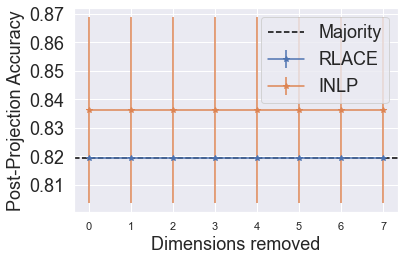

In [48]:
plot(proj2attrdf["rlace"], proj2attrdf["inlp"], "Dimensions removed", "Post-Projection Accuracy", "gender_stereo.pdf", get_maj(z_test), baseline_label="Majority")